### Portland General Electric Demand Modeland Temperature Analysis for 2021

This is a quick model to estimate PGE's demand given temperature, and time of day. 

This is a quick analysis to identify if there is a correlation between Portland General Electric (PGE) hourly demand, demand forecast, and daytime mean temperature. 

This notebook will also serve as a guide for creating API calls on the EIA website. 

Background: PGE is a major public utility which distributes electricty to 44% of Oregon's inhabitants (including customers in Multnomah county). 

The year 2021 was selected as Oregon experienced [record temperatures](https://www.opb.org/article/2022/02/10/oregons-2021-heat-dome-notches-another-record/). Some parts of oregon reached 119F. 

The data for this analysis comes from the U.S. Energy Information Administration (https://www.eia.gov/opendata/). Data is made available via their public API. 

### Using EIA for energy data 
To use EIA for energy data, first, generate an API key using this link: 
https://www.eia.gov/opendata/register.php

Save the api key to an `.env` file in your project directory. 
The file should have a format similar to a bash environmental variable: 

EIA_API_KEY=your_key

This will later be sourced by the notebook. 

### Creating GET requests for EIA data 

EIA has a helpful [API browser](https://www.eia.gov/opendata/browser/) with a GET request formulater. 

For this project, the following is used:

API ROUTE:  
- Electricity
- Electric Power Operations (Daily and Hourly) 
- Hourly Demand, Demand Forecast, Generation, And Interchange  

Frequency: 
- Hourly
- Start: January 1, 2021 
- End: December 21, 2021  

Filtered by:
- Balancing Authority / Region: (PGE) Portland General Electric Company

These filters generate an **API URL** of:  
`https://api.eia.gov/v2/electricity/rto/region-data/data/?frequency=hourly&data[0]=value&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000`

The API key needs to be added to all EIA urls. Add it immediately after the `?` symbol (which delimits the boundary between the URI object and query parameters). 

It becomes:  
`https://api.eia.gov/v2/electricity/rto/region-data/data/?api_key={EIA_API_KEY}&frequency=hourly&data[0]=value&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000`


## Definitions from Hourly Electric Grid Monitor (EIA-930 data)
"Form EIA-930 data collection provides a centralized and comprehensive source for hourly operating data about the high-voltage bulk electric power grid in the Lower 48 states."
You can read more Form DIA-930 data collecton [here](https://www.eia.gov/electricity/gridmonitor/about). 


"Balancing Authorities (BAs)... are mainly responsible for balancing electricity supply, demand, and interchange on their electric systems in real time."

"**Demand** is a calculated value representing the amount of electricity load within a BA's electric system. A BA derives its demand value by taking the total metered net electricity generation within its electric system and subtracting the total metered net electricity interchange occurring between the BA and its neighboring BAs."

"**Demand forecast:** Each BA produces a day-ahead electricity demand forecast for every hour of the next day. These forecasts help BAs plan for and coordinate the reliable operation of their electric system."

"**Net generation and net generation by energy source:** Net generation represents the metered output of electric generating units in a BA's electric system. This generation only includes generating units that are managed by a BA or whose operations are visible to a BA."

**TIME REPORTING**   
**period** is a time-weighted hourly average value. Data are published at the **end** of the hour. "For example, the data for the hour ending 1:00 a.m. on August 1, 2019, is reported with a timestamp of August 1, 2019, 1:00 a.m." Data is reported in local timezones. So, **PGE's data, it is reported in Pacific Time (PT).**



Source: https://www.eia.gov/electricity/gridmonitor/about

# ASSUMPTIONS AND IMPROVEMENTS:
1. Right now, temperature is represented as temperature in Portland, OR. It would be better to use a mean weighted temperature for the areas that PGE serves. More customers in an area would get a higher temperature weight. 
However, most of Oregon's population in concentrated in the Portland metro area (2.5M people of Oregon's 4.2M population).  
Therefore, the temperature in Portland is selected as a representative temperature. 

2. For this analysis, I assumed that the temperature data from https://open-meteo.com/ is reliable. However, I didn't cross check it against any other historic weather APIs. I'd like to look into that data source more. 



#### FURTHER INVESTIGATION IDEAS: 
1. Would be interesting to see how R^2 changes over time... assuming their modeling capabilities get better over time, plot R^2 as a function of time per month... although the data only goes back to 2015. 

In [542]:
import requests
import json
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from dotenv import dotenv_values #reads key-value pairs from a .env file and can set them as environment variables

In [517]:
# This loads the shell environment into the jupyter notebook environment
# So it is possible to get environmental variables that are in the .env file in the shell into this environment 
%load_ext dotenv
%dotenv -o -v

# Get the EIA_API_KEY from the environment 
EIA_API_KEY = os.environ.get("EIA_API_KEY")

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


### EIA API Call 
Below, the API call is made to get PGE's hourly demand and demand forecast data. 
#### NOTE on Limits, and Pagination 
"EIA's API limits its data returns to the first 5,000 rows responsive to the request."
[source](https://www.eia.gov/opendata/documentation.php)

Therefore, 12 calls will be made; one for each month. Then, the 12 calls will be concatenated into one pandas dataframe. 

In [519]:
# List of tuples consisting of (month number, number of days in month)... quick, and not cute. But it works
months = [('01','31'),('02','28'),('03','31'),('04','30'),('05','31'),('06','30'),
          ('07','31'),('08','31'),('09','30'),('10','31'),('11','30'),('12','31')]
# empty dataframe to concatentate the data into 
dfs = []

for month in months: 
    eia_url = ('https://api.eia.gov/v2/electricity/rto/region-data/data/?' +
          f'api_key={EIA_API_KEY}&' +
          'frequency=hourly&' +
          'data[0]=value&' +
          'facets[respondent][]=PGE&' +
          f'start=2021-{month[0]}-01T00&end=2021-{month[0]}-{month[1]}T23&' +
          'sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000')
    response = requests.get(eia_url)
    eia_json = response.json()
    month_dataframe = pd.DataFrame.from_dict(eia_json['response']['data'])
    dfs.append(month_dataframe)


Concatenate the monthly data into one dataframe for 2021 

In [520]:
pge_all_data = pd.concat(dfs)

In [521]:
# There is a single null value that is dropped 
pge_all_data.dropna(inplace=True)

In [522]:
# Preview the data
pge_all_data.head(8)

,period,respondent,respondent-name,type,type-name,value,value-units
0,2021-01-31T23,PGE,Portland General Electric Company,D,Demand,2539.0,megawatthours
1,2021-01-31T23,PGE,Portland General Electric Company,TI,Total interchange,-1870.0,megawatthours
2,2021-01-31T23,PGE,Portland General Electric Company,NG,Net generation,669.0,megawatthours
3,2021-01-31T23,PGE,Portland General Electric Company,DF,Day-ahead demand forecast,2536.0,megawatthours
4,2021-01-31T22,PGE,Portland General Electric Company,D,Demand,2582.0,megawatthours
5,2021-01-31T22,PGE,Portland General Electric Company,TI,Total interchange,-2016.0,megawatthours
6,2021-01-31T22,PGE,Portland General Electric Company,NG,Net generation,566.0,megawatthours
7,2021-01-31T22,PGE,Portland General Electric Company,DF,Day-ahead demand forecast,2566.0,megawatthours


Clean the data a bit to get all of the data types into their expected format:  
- `period` needs to be updated from `object` to `datetime64`  
- `respondent`, `respondent-name`, `type`, `type-name`, and `value-units` can remain as `object`  
- `value` can remain as `float64`

In [523]:
pge_all_data['period']= pd.to_datetime(pge_all_data['period'])
# Also do a sort of the data to ensure it is sorted ascending by time 
pge_all_data.sort_values(by='period', inplace=True)

## Get historic weather data for Portland, OR 

The weather data is sourced using this api: https://open-meteo.com/
Time is in **Pacific Time**. 
Temperature is the air temperature at 2 meters above ground. 
Data is for Portland, OR 

In [524]:
weather_url = ('https://archive-api.open-meteo.com/v1/archive?' +
               'latitude=45.52&longitude=-122.68&' +
               'start_date=2021-01-01&end_date=2021-12-31&' +
               'hourly=temperature_2m&' +
               'timezone=America%2FLos_Angeles&' +
               'temperature_unit=fahrenheit&windspeed_unit=ms&precipitation_unit=inch')

response = requests.get(weather_url)

In [525]:
weather_data = response.json()
hourly_temp = pd.DataFrame.from_dict(weather_data['hourly'])
hourly_temp['time']= pd.to_datetime(hourly_temp['time'])
hourly_temp.rename(columns={"temperature_2m": "temp"}, inplace=True)
hourly_temp.head(5)

,time,temp
0,2021-01-01 00:00:00,45.3
1,2021-01-01 01:00:00,45.5
2,2021-01-01 02:00:00,45.4
3,2021-01-01 03:00:00,45.4
4,2021-01-01 04:00:00,45.5


## Join energy and temperature data

In [526]:
energy_and_temp = pge_all_data.merge(hourly_temp, how='inner', left_on='period', right_on='time')
# Only keep the columns of interest
energy_and_temp = energy_and_temp.loc[:,['respondent', 'type-name', 'value', 'value-units', 'time', 'temp']]

In [527]:
energy_and_temp.head()

,respondent,type-name,value,value-units,time,temp
0,PGE,Total interchange,-2153.0,megawatthours,2021-01-01 00:00:00,45.3
1,PGE,Net generation,544.0,megawatthours,2021-01-01 00:00:00,45.3
2,PGE,Day-ahead demand forecast,2800.0,megawatthours,2021-01-01 00:00:00,45.3
3,PGE,Demand,2697.0,megawatthours,2021-01-01 00:00:00,45.3
4,PGE,Day-ahead demand forecast,2918.0,megawatthours,2021-01-01 01:00:00,45.5


## Filter data by type-name (demand, generation, forecast)
Now, separate out the different data types in the dataframe 

In [528]:
demand = energy_and_temp.loc[(energy_and_temp['type-name'] == 'Demand')].copy()
demand.rename(columns={"value": "demand"}, inplace=True)
generation = energy_and_temp.loc[(energy_and_temp['type-name'] == 'Net generation')] 
forecast = energy_and_temp.loc[(energy_and_temp['type-name'] == 'Day-ahead demand forecast')].copy()
forecast.rename(columns={"value": "forecast"}, inplace=True)

## Plot of energy usage and temperature over time

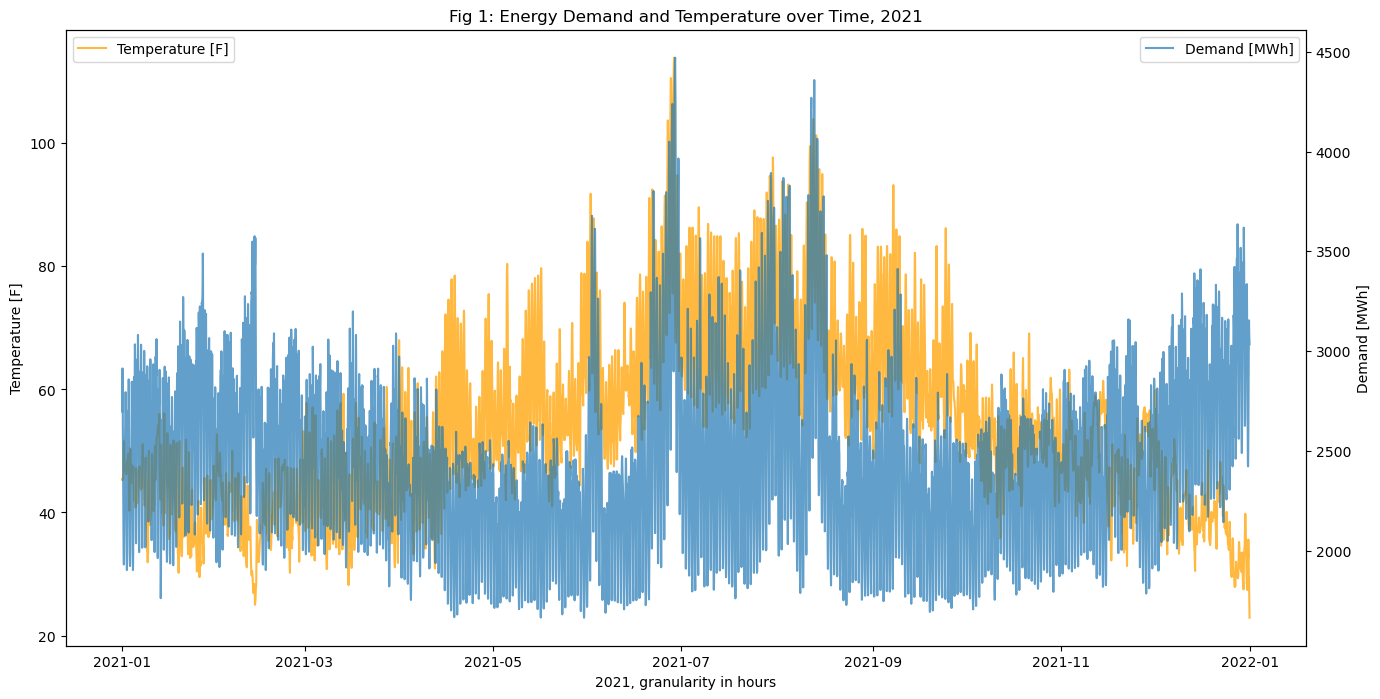

In [529]:
fig, ax1 = plt.subplots(figsize=(16, 8))
ax2 = ax1.twinx()
plt.title("Fig 1: Energy Demand and Temperature over Time, 2021")

ax1.plot(demand['time'], demand['temp'], label='Temperature [F]', color="#ffb940") # orange color
ax2.plot(demand['time'], demand['demand'], label='Demand [MWh]', alpha=0.7)

ax1.set_xlabel('2021, granularity in hours')
ax1.set_ylabel('Temperature [F]')
ax2.set_ylabel('Demand [MWh]')

ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

## PGE's Demand Forecasing 
Below, compare PGE's demand to their demand forecast for the next day.


NOTE: I believe the `Day-ahead demand forecast` values have already been appropriately shifted to be in the same row as the date they supposedly forecast for. 
I originally assumed they would need to be shifted to a day later. After manually shifting it, the R^2 value dropped from 0.95 to 0.74. 
Of course, they *may* need to be shifted, but I would be surprised if their R^2 value for forecasting was that low. 

In [530]:
demand_forecast = forecast.merge(demand, how='inner', left_on='time', right_on='time')

Getting the fit for PGE's demand vs forecast.  
Doing a simple linear regression of form `y=mx+B`

In [531]:
# demand array must be 2D, reshape() makes this nympy array 2D
# reshape is a numpy operator, so use .values to turn the pd series into a np array 
demand_x = demand_forecast['demand'].values.reshape(-1,1)
forecast_y = demand_forecast['forecast'].values.reshape(-1,1)
model = LinearRegression().fit(demand_x, forecast_y)
r_sq = model.score(demand_x, forecast_y)
print(r_sq, model.intercept_, model.coef_)

0.95993211409628 [15.4595371] [[0.99893615]]


The R^2 value for the fit is 0.96  
The y-intercept (B) is 15.48  
The slope (x) is ~1.00 (as expected)

Let's plot the data on a scatter plot with the linear fit 

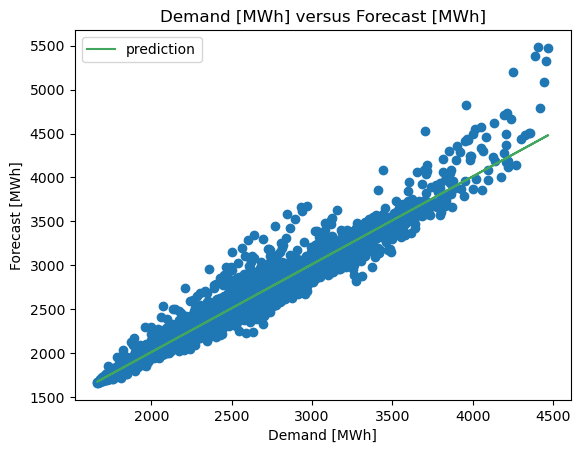

In [541]:
plt.title('Demand [MWh] versus Forecast [MWh]')
plt.xlabel("Demand [MWh]")
plt.ylabel("Forecast [MWh]")
plt.scatter(demand_x, forecast_y)

plt.plot(demand_x, model.coef_ * demand_x + model.intercept_, label='prediction', color="#42a65e")
plt.legend()



## Creating a Model
There are a few obvious variables from looking at Fig 1 that should be investigated: 
- temperature
- week in the year (to account for seasonal fluctuations)
- time of day 
- day of week 

It is clear that when temperatures are very high, or very low, energy demand increases due to need for heat or AC. 
When temperatures are moderate (spring and fall), energy demand falls, as likely many people do not run heat and AC as much. 

Temperature and demand are **not** homoscedastic -- the variance of the data is NOT the same over the time range. 

## Plot of temperature versus demand

Appears parabolic. To complete model, may also want to add a time of day variable.

Fit a model of form y = ax^2 + bx + c

In [550]:
temp_x = demand['temp'].values.reshape(-1,1)
demand_y = demand['demand'].values.reshape(-1,1)

transformer = PolynomialFeatures(degree=2, include_bias=False)
x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(temp_x)
model = LinearRegression().fit(x_, demand_y)

In [552]:
r_sq = model.score(x_, demand_y)
print(r_sq, model.intercept_, model.coef_)

0.08918886160970052 [4019.95573635] [[-51.76910064   0.3971598 ]]


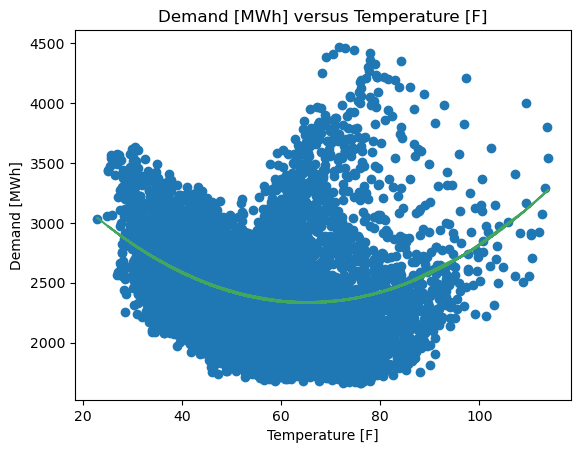

In [574]:
plt.title('Demand [MWh] versus Temperature [F]')
plt.xlabel("Temperature [F]")
plt.ylabel("Demand [MWh]")
plt.scatter(temp_x, demand_y)
# print(model.coef_[0][1])
plt.plot(temp_x, (model.coef_[0][0] * temp_x + model.coef_[0][1]* temp_x**2 + model.intercept_), label='prediction', color="#42a65e")

